In [ ]:
# Please provide appropriate path for market data.
warehouse_path = "C:\\Users\\Aditya\\Desktop\\Aditya\\Data-20250729T080114Z-1-001\\Data\\FROG"

# Minimizing Total Temporary Impact of Order Execution

## Problem Statement
Let us define the temporary impact function $g_t(X)$ as the amount of slippage you incur if you place $X$ orders at the current time $t$. Let us suppose that we have $S$ total amount of orders to be bought, you are given how many shares $S$ to buy before market opens, and must buy exactly $S$ shares by end of day. You are tasked with creating a strategy that is supposed to minimize the total temporary impact of the executed orders. Mathematically speaking, let $g_t(X)$ be the temporary impact function at some time $t$. Let us split the day into $N$ trading periods. Let $x ∈ R^N$ be your allocation vector (we generally have to take integer quantities but real numbers are okay for now) where you choose to buy $x_i$ shares at the $i$th period. Given data for $N = 390$ (one minute trading window) and data for 3 stocks. Please answer the following questions:

## 1. How to Model the Temporary Impact $g_t(x)$?
How do you choose to model the temporary impact $g_t(x)$? For example, sometimes people try to ”linearize” the model $g_t(x) ≈ \beta_t x$. If you think linear models are gross oversimplifications, how would you model it? Please write a 1-2 page explanation on your model, using data from the 3 tickers provided. We understand that 3 tickers is not enough data so any valid reasoning/conclusions derived from these 3 tickers would be accepted. Please also attach a link to a python notebook or code (prefably uploaded on GitHub) where you conducted your analysis.

## 2. Mathematical Framework for Allocating $x_i$ at Each Period
Formulate roughly but rigorously a mathematical framework/algorithm that gives us $x_i$ when we are at time $t_i$ . Make sure that i $\sum_{i=1}^{N} x_i = S$. This should be relatively short, at most 2 pages. You don’t have to fully solve the problem, but a clear mathematical setup and discourse into the techniques + tools used to solve the problem would be sufficient.

## Solution 1. How to Model the Temporary Impact $g_t(x)$?
### Compare available funtions with actual slippage value
We will plot actual slippage values and compare with various mathematical functions for approximations.

### 1. $g_t(x) \approx \alpha x + \beta \sqrt x$
Since the slippage graph on sample data looks like square root function, but on comparing their plots, we see it "lacks" linearity. So, let us "add" linear component to mimic that.

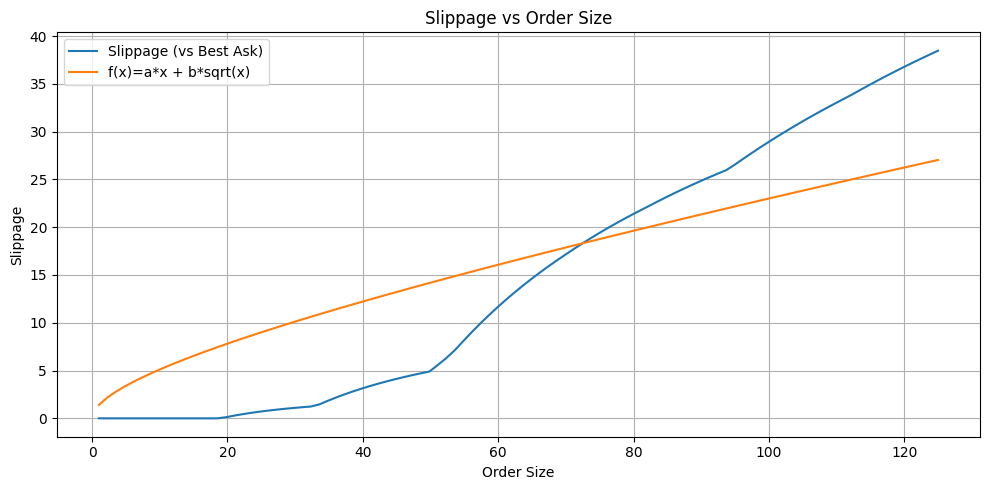

In [5]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculateSplippage(prices, quantities, S):
    slippages = []
    cumulative_quantities = np.cumsum(quantities)
    total_available = cumulative_quantities[-1]
    order_sizes = np.linspace(1, total_available, S)
    for size in order_sizes:
        remaining = size
        cost = 0
        filled = 0
        for price, qty in zip(prices, quantities):
            take = min(qty, remaining)
            cost += take * price
            filled += take
            remaining -= take
            if remaining <= 0:
                break
        avg_fill_price = cost / filled
        best_price = prices[0]
        slippage = avg_fill_price - best_price
        slippages.append(slippage)
    return slippages, order_sizes

S = 100
# Ask side of the book.
prices = np.sort(np.random.choice(100, size=10, replace=False))
quantities = np.random.randint(low=0, high=20, size=10)
actual_slippage, order_sizes = calculateSplippage(prices, quantities, S)

alpha = 0.1
beta = 1.3
approx_slippage = alpha * order_sizes + beta * np.sqrt(order_sizes)

plt.figure(figsize=(10, 5))
plt.plot(order_sizes, actual_slippage, label='Slippage (vs Best Ask)')
plt.plot(order_sizes, approx_slippage, label='f(x)=a*x + b*sqrt(x)')
plt.xlabel('Order Size')
plt.ylabel('Slippage')
plt.title('Slippage vs Order Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2. $g_t(x) \approx \delta + \alpha x + \beta x ^ \gamma$
Let us check how does the slippage function compares to exponential functions with their "linear" component and the "bias" term.

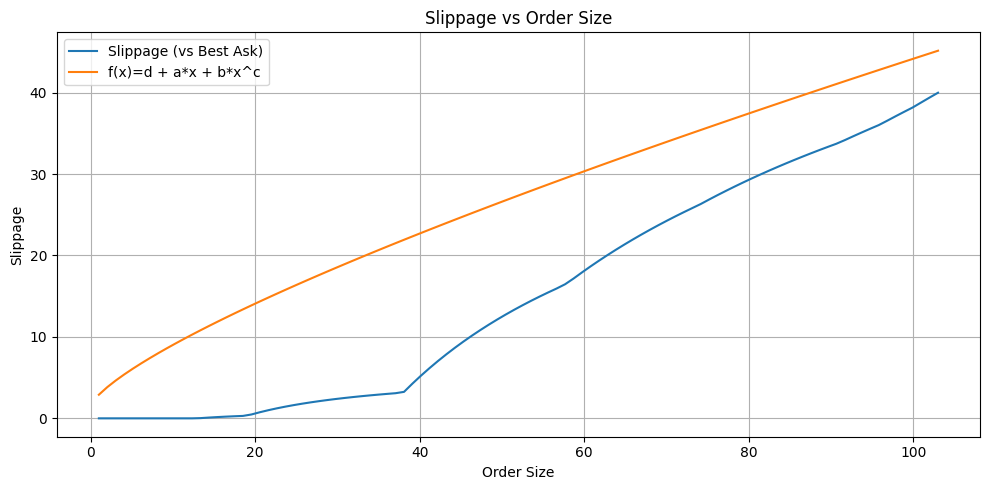

In [8]:
S = 100
# Ask side of the book.
prices = np.sort(np.random.choice(100, size=10, replace=False))
quantities = np.random.randint(low=0, high=20, size=10)
actual_slippage, order_sizes = calculateSplippage(prices, quantities, S)

alpha = 0.1
beta = 1.3
gamma = 0.7
delta = 1.5
approx_slippage = alpha * order_sizes + beta * np.pow(order_sizes, gamma)
approx_slippage = approx_slippage + delta

plt.figure(figsize=(10, 5))
plt.plot(order_sizes, actual_slippage, label='Slippage (vs Best Ask)')
plt.plot(order_sizes, approx_slippage, label='f(x)=d + a*x + b*x^c')
plt.xlabel('Order Size')
plt.ylabel('Slippage')
plt.title('Slippage vs Order Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Working on Real Dataset
Let us bring the real dataset and do the same comparision. We will pick the order book snapshot for each minute only and not all the events provided in the dataset, since we want to execute our orders per minute basis.

In [ ]:
class Dataset:
    def __init__(self, path: str, symbol: str, min_order_size: int, max_order_size: int, train_test_ratio: float):
        self.path = path
        self.symbol = symbol
        self.ratio = train_test_ratio
        self.min_order_size = min_order_size
        self.max_order_size = max_order_size
        streams = glob.glob(os.path.join(self.path, f"{self.symbol}*.csv"))
        self.X = pd.concat((pd.read_csv(f) for f in streams), ignore_index=True)
        self.X.drop(["symbol", "ts_event.1", "rtype", "publisher_id", \
                     "instrument_id", "action", "side", "depth", \
                     "price", "size", "flags", "ts_in_delta", "sequence"], \
                    axis=1, inplace=True)
        self.X.drop([f"bid_ct_0{i}" for i in range(10)], axis=1, inplace=True)
        self.X.drop([f"ask_ct_0{i}" for i in range(10)], axis=1, inplace=True)
        # Since, for this problem we are concerned about slippage in buying, so we take only ask side price levels.
        self.X.drop([f"bid_px_0{i}" for i in range(1,10)], axis=1, inplace=True)
        self.X.drop([f"bid_sz_0{i}" for i in range(1,10)], axis=1, inplace=True)
        self.X['ts_event'] = pd.to_datetime(self.X['ts_event'])
        self.X.set_index('ts_event', inplace=True)
        # self.X = self.X.resample('1min').first().dropna(how='any')
        # display(self.X)
        self.Y = pd.DataFrame()
        for i in range(self.min_order_size, max_order_size + 1):
            self.Y[f'g_{i}'] = self.get_slippage(self.X, 'B', i)

    def get_slippage(self, df: pd.DataFrame, side: chr, max_order_size: int):
        px_cols = None
        sz_cols = None
        if side == 'B':
            px_cols = [f'ask_px_0{i}' for i in range(10)]
            sz_cols = [f'ask_sz_0{i}' for i in range(10)]
        elif side == 'S':
            px_cols = [f'bid_px_0{i}' for i in range(10)]
            sz_cols = [f'bid_sz_0{i}' for i in range(10)]
        order_size = np.full(df.shape[0], max_order_size)
        order_size_expanded = order_size[:, None]
        fill_qty = np.minimum(df[sz_cols], np.maximum(0, \
                        order_size_expanded - np.cumsum(np.pad(df[sz_cols], \
                        ((0, 0), (1, 0)), constant_values=0)[:, :-1], axis=1)))
        total_cost = np.sum(fill_qty.to_numpy() * df[px_cols].to_numpy(), axis=1)
        exec_price = total_cost / order_size
        mid_price = (df['ask_px_00'] + df['bid_px_00']) / 2
        return ((exec_price - mid_price) if side == 'B' else (mid_price - exec_price))

    def getX(self, year, month, day, hh, minute):
        train_size = int(self.X.shape[0] * self.ratio)
        x_train = self.X.iloc[:train_size]
        y_train = self.Y.iloc[:train_size]
        return [x_train, y_train]

    def getY(self, year, month, day, hh, minute):
        test_size = int(self.X.shape[0] * (1.0 - self.ratio))
        x_test = self.X.iloc[:test_size]
        y_test = self.Y.iloc[:test_size]
        return [x_test, y_test]

S_min = 500
S_max = 600
dset = Dataset(warehouse_path, "FROG", S_min, S_max, 0.9)

C:\Users\Riya\AppData\Local\Temp\ipykernel_11964\1209788940.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.Y[f'g_{i}'] = self.get_slippage(self.X, 'B', i)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

x_np = np.tile(np.arange(S_min, S_max + 1), (dset.X.shape[0], 1))
x = torch.tensor(x_np, dtype=torch.float32)
true_y = torch.tensor(dset.Y.to_numpy(), dtype=torch.float32)
y = true_y

delta = torch.nn.Parameter(torch.randn(1))
alpha = torch.nn.Parameter(torch.randn(1))
beta = torch.nn.Parameter(torch.randn(1))
gamma = torch.nn.Parameter(torch.tensor([0.5]))  # Initialize d near 0.5

optimizer = optim.Adam([delta, alpha, beta, gamma], lr=1e-2)

for i in range(400):
    optimizer.zero_grad()
    y_pred = delta + alpha * x + beta * (x ** gamma)
    loss = torch.mean((y_pred - y)**2)
    loss.backward()
    optimizer.step()
    if i % 200 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}, delta={delta.item():.2f}, alpha={alpha.item():.2f}, beta={beta.item():.2f}, gamma={gamma.item():.2f}")     

Step 0, Loss: 61752.8867, delta=1.08, alpha=0.50, beta=-1.52, gamma=0.51
Step 200, Loss: 5.9053, delta=0.85, alpha=0.28, beta=-1.72, gamma=0.71


## Conclusion from empirical analysis
We can se that the exponetial function $f(x) = \delta + \alpha x + \beta x ^ \gamma$ roughly fits the temporary market impact (or the slippage) curve. If we can optimize for the right values through various optimization methods, we can reach a proper fit to model temporary market impact.

## Solution 2. Mathematical Framework for Allocating $x_i$ at Each Period
According to _Almgren and Chriss Model_, the price dynamics can be represented as,
$S_t=\bar{S_t} + \eta v_t + \theta (X_0 - X_t)$ \
where, $\eta v_t$ gives temporary market impact that scales with trading speed $v_t$

The final cost of execution can be represented as:\
$C_{0,T}=\int_0^T S_t v_t \,dt$ ... _eq (1)_\
We need to minimize both the expectation of final cost and the variance of the final cost: \
$min_{v_t} (E[C] + \lambda Var[C])$ \
$min_{v_t} \int_0^T v_t^2/ \,dt + \lambda \sigma ^ 2 \bar{S_0^2} \int_0^T X_t^2 \,dt$ \
Solving for which gives us the value of $X_t$ that we should buy at time interval $t$ \
$X_t=X_0 \frac{sinh(\sqrt \frac{\eta}{\lambda \sigma ^ 2 \bar{S_0}}T-t)}{sinh(\sqrt \frac{\eta}{\lambda \sigma ^ 2 \bar{S_0}}T)}$ \
where we can see from the given function that most of the quantities are traded in the initial trading hours.


References:
1. _Optimal Execution of Portfolio Transactions_: Robert Almgren and Neil Chriss, December 2000